In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
# import torchsummary

import sys

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stdout = sys.stdout

In [2]:
# model architecture and training

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_one = nn.Linear(
            in_features=kwargs["input_width"], 
            out_features=kwargs["hidden_width"], 
            bias=kwargs["bias"]
        )
        self.encoder_two = nn.Linear(
            in_features=kwargs["hidden_width"], 
            out_features=kwargs["code_width"], 
            bias=kwargs["bias"]
        )
        
        self.decoder_one = nn.Linear(
            in_features=kwargs["code_width"], 
            out_features=kwargs["hidden_width"], 
            bias=kwargs["bias"]
        )
        
        self.decoder_two = nn.Linear(
            in_features=kwargs["hidden_width"], 
            out_features=kwargs["input_width"], 
            bias=kwargs["bias"]
        )
        
        if kwargs['linear']:
            self.activation = lambda x: x
        else:
            self.activation = F.relu

    def forward(self, x):
        shape = x.shape
        x = torch.flatten(x, start_dim=1)
        x = self.activation(self.encoder_one(x))
        x = self.activation(self.encoder_two(x))
        x = self.activation(self.decoder_one(x))
        x = self.activation(self.decoder_two(x))
        x = torch.reshape(x, shape)
        return x
    
    
def train(model, epochs, train_loader, optimizer, criterion, verbose=True):
    for epoch in range(epochs):
        model.train()
        loss = torch.zeros((), device = device)
        
        for data in train_loader:
            batch_features, _ = data
            batch_features = batch_features.to(device)
            optimizer.zero_grad()

            outputs = model(batch_features)
            train_loss = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        loss = loss / len(train_loader)
        if verbose:
            print("{};{:.6f}".format(epoch + 1, loss))
    return model

training samples: 60000
loader length: 60


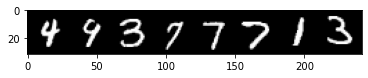

In [3]:
# load and visualize data

set0 = tv.datasets.MNIST("../MNIST/", 
                         download=True, 
                         train = True,
                         transform = tv.transforms.ToTensor())
loader0 = torch.utils.data.DataLoader(set0, 
                                     batch_size = 1000, 
                                     shuffle = True)
print("training samples: " + str(len(set0)) + 
     "\nloader length: " + str(len(loader0)))

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(loader0)
image, _ = dataiter.next()

imshow(tv.utils.make_grid(image[:8]))

In [4]:
# hyperparams

params = {
    # data    
    "input_width": 28*28, 
    
    # model
    "linear":False,
    "bias": False,
    
    # training
    "lr": 1e-3,
    "epochs": 50
}

hidden layer width = 10
code width = 1


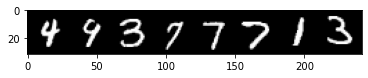

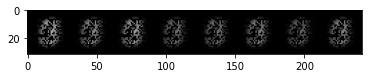

hidden layer width = 20
code width = 1


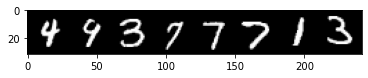

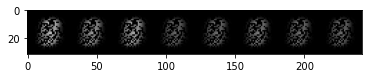

hidden layer width = 10
code width = 2


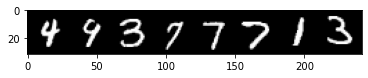

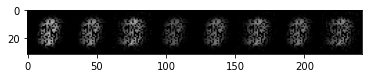

hidden layer width = 20
code width = 2


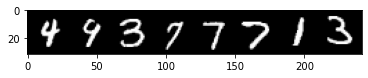

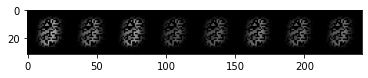

In [5]:
for code_width in [1,2,5,10]:
    for hidden_width in [10, 20, 50, 100]:
        model = AE(**params,
                   **{"code_width":code_width, 
                      "hidden_width":hidden_width}
                  ).to(device)
        opt = optim.Adam(model.parameters(), lr=params['lr'])
        crit = nn.MSELoss(reduction='mean')
#         torchsummary.summary(model, input_size=(1,28,28))
        
        print("hidden layer width = " + str(hidden_width) +
              "\ncode width = " + str(code_width))
        
        sys.stdout = open("log/AE-" + str(code_width) + 
                          "-" + str(hidden_width) + 
                          ".txt", "w")
        
        model_trained = train(model, 
                              params["epochs"], 
                              loader0, 
                              opt, 
                              crit, 
                              verbose=True)
        
        sys.stdout.close()
        sys.stdout = stdout
        
        # visualise results
        res = model_trained(image[:8])

        imshow(tv.utils.make_grid(image[:8]))
        imshow(tv.utils.make_grid(res.detach()))